In [2]:
import pandas as pd 
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, LSTM, Embedding, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
from imblearn.under_sampling import ClusterCentroids
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    precision_score, recall_score, f1_score,
    confusion_matrix,
    classification_report)
from sklearn.metrics import precision_recall_curve, roc_curve, auc


In [3]:
dt = pd.read_csv('emails.csv')
dt

,Email No.,the,to,ect,and,for,of,a,you,hou,...,connevey,jay,valued,lay,infrastructure,military,allowing,ff,dry,Prediction
0,Email 1,0,0,1,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Email 2,8,13,24,6,6,2,102,1,27,...,0,0,0,0,0,0,0,1,0,0
2,Email 3,0,0,1,0,0,0,8,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Email 4,0,5,22,0,5,1,51,2,10,...,0,0,0,0,0,0,0,0,0,0
4,Email 5,7,6,17,1,5,2,57,0,9,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5167,Email 5168,2,2,2,3,0,0,32,0,0,...,0,0,0,0,0,0,0,0,0,0
5168,Email 5169,35,27,11,2,6,5,151,4,3,...,0,0,0,0,0,0,0,1,0,0
5169,Email 5170,0,0,1,1,0,0,11,0,0,...,0,0,0,0,0,0,0,0,0,1
5170,Email 5171,2,7,1,0,2,1,28,2,0,...,0,0,0,0,0,0,0,1,0,1


Exploratory Data Analysis

<Axes: xlabel='Prediction'>

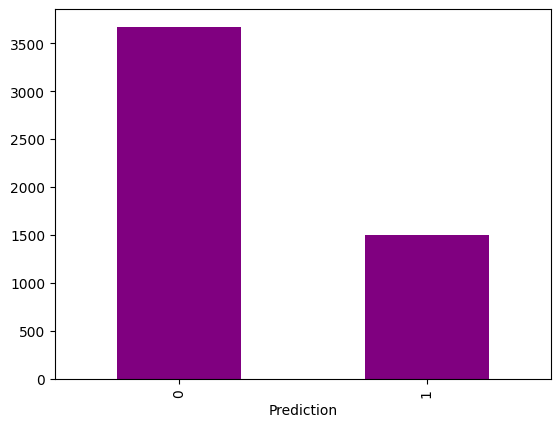

In [3]:
# Target Variable Frequency 

dt.groupby('Prediction').count()['Email No.'].plot(kind = 'bar',color='purple')

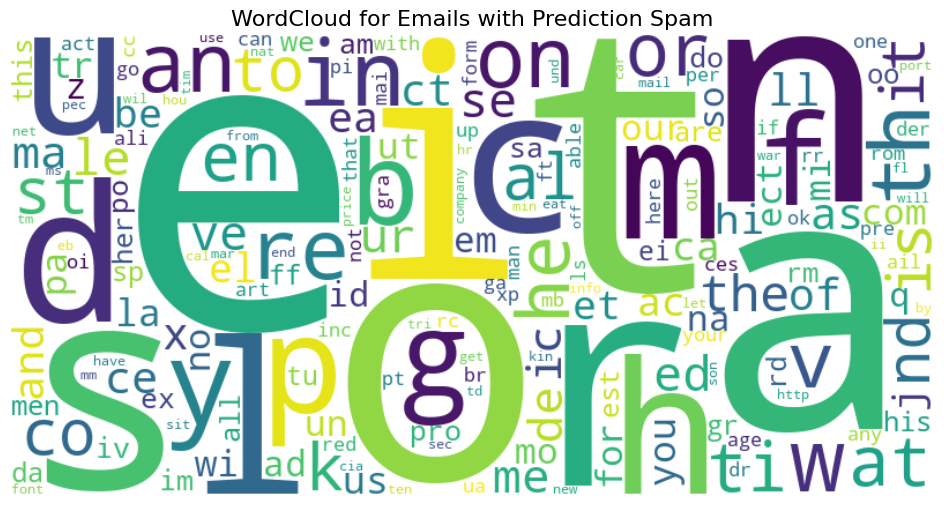

In [12]:
# Filter the data for Prediction = 1
positive_emails = dt[dt['Prediction'] == 1].iloc[:, 1:-1]  # Exclude 'Email No.' and 'Prediction'

# Sum word frequencies across all rows where Prediction = 1
word_frequencies = positive_emails.sum()

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_frequencies)

# Plot the WordCloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud for Emails with Prediction Spam', fontsize=16)
plt.show()

Evaluation Metrics

In [9]:
def score(y_true, y_pred,y_proba):

    # Accuracy, Precision, Recall, F1-Score
    acc = accuracy_score(y_true, y_pred)* 100 
    precision = precision_score(y_test, y_pred) * 100
    recall = recall_score(y_test, y_pred) * 100
    f1 = f1_score(y_test, y_pred) * 100

     # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    labels = np.unique(y_true)
    
    # Confusion Matrix Plot
    plt.figure(figsize=(4,2))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()
    
    return {
        "Accuracy (%)": f"{acc:.2f}",
        "Precision (%)": f"{precision:.2f}",
        "Recall (%)": f"{recall:.2f}",
        "F1-Score (%)": f"{f1:.2f}"
    }

Oversampling for Data Balancing

SMOTE generates synthetic examples for the minority class by interpolating between existing samples, thereby increasing the representation of the minority class without duplication.

In [10]:
# Separate features and target
X = dt.iloc[:, 1:-1].values  # Exclude 'Email No.' and 'Prediction'
y = dt['Prediction'].values

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

# Further split of the training set (90% train, 10% validation from training data)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.10, random_state=42
)

# Oversampling for the training data
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Check class distribution
print("Train class distribution:")
print(pd.Series(y_train).value_counts(normalize=True))

print("Validation class distribution:")
print(pd.Series(y_val).value_counts(normalize=True))

print("Test class distribution:")
print(pd.Series(y_test).value_counts(normalize=True))

Train class distribution:
0    0.5
1    0.5
Name: proportion, dtype: float64
Validation class distribution:
0    0.719807
1    0.280193
Name: proportion, dtype: float64
Test class distribution:
0    0.71401
1    0.28599
Name: proportion, dtype: float64


In [11]:
# Compute class weight
class_weights = compute_class_weight('balanced', classes = np.unique(dt['Prediction']), y =dt['Prediction'])
class_weight_dict = dict(enumerate(class_weights))
print(class_weight_dict)

{0: 0.704248366013072, 1: 1.724}


In [12]:
# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

The F1-score considers both precision and recall, making it a suitable metric for imbalanced datasets where one class is much larger than the other.
It helps us assess how well the model handles the minority class, which might be overlooked by accuracy. Keras does not directly support F1-score as a built-in metric. We need to write a custom metric:

In [13]:
# Define F1 score metric
import tensorflow_addons as tfa
f1_metric = tfa.metrics.F1Score(num_classes=1, average='micro', threshold=0.5)

C:\Users\B590\anaconda3\envs\tf\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


I am going to use three classifiers to find the one with the best F1-score.

Epoch 1/17
165/165 - 8s - loss: 0.5322 - accuracy: 0.7533 - f1_score: 0.7725 - val_loss: 0.2569 - val_accuracy: 0.8937 - val_f1_score: 0.8406 - 8s/epoch - 48ms/step
Epoch 2/17
165/165 - 1s - loss: 0.1905 - accuracy: 0.9201 - f1_score: 0.9240 - val_loss: 0.1130 - val_accuracy: 0.9589 - val_f1_score: 0.9306 - 1s/epoch - 7ms/step
Epoch 3/17
165/165 - 1s - loss: 0.1325 - accuracy: 0.9476 - f1_score: 0.9491 - val_loss: 0.0516 - val_accuracy: 0.9783 - val_f1_score: 0.9620 - 1s/epoch - 6ms/step
Epoch 4/17
165/165 - 1s - loss: 0.0926 - accuracy: 0.9649 - f1_score: 0.9655 - val_loss: 0.0402 - val_accuracy: 0.9831 - val_f1_score: 0.9702 - 1s/epoch - 7ms/step
Epoch 5/17
165/165 - 1s - loss: 0.0854 - accuracy: 0.9702 - f1_score: 0.9706 - val_loss: 0.1002 - val_accuracy: 0.9807 - val_f1_score: 0.9664 - 1s/epoch - 7ms/step
Epoch 6/17
165/165 - 1s - loss: 0.0804 - accuracy: 0.9738 - f1_score: 0.9742 - val_loss: 0.0911 - val_accuracy: 0.9758 - val_f1_score: 0.9583 - 1s/epoch - 7ms/step
Epoch 7/17
165/

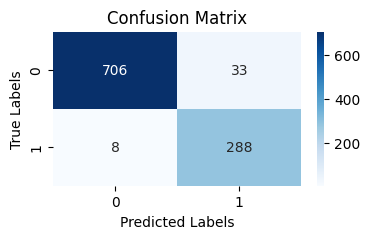

{'Accuracy (%)': '96.04',
 'Precision (%)': '89.72',
 'Recall (%)': '97.30',
 'F1-Score (%)': '93.35'}

In [14]:
# Dense Neural Network
model = Sequential([
    Dense(32, activation='relu', input_dim=X_train.shape[1]),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(1, activation='sigmoid')  
])

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer= optimizer, loss='binary_crossentropy', metrics=['accuracy', f1_metric])

# Fit the model
dense_hist=model.fit(X_train,
               y_train,
               epochs=17,
               batch_size=32,
               validation_data=(X_val,y_val),
               verbose=2,
               class_weight = class_weight_dict)

# Evaluate the model
y_proba = model.predict(X_test)  # Predicted probabilities
y_pred = (y_proba > 0.5).astype(int) # final prediction 
y_true = np.array(y_test)    # true label

score(y_true, y_pred, y_proba)

In [15]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.96      0.97       739
           1       0.90      0.97      0.93       296

    accuracy                           0.96      1035
   macro avg       0.94      0.96      0.95      1035
weighted avg       0.96      0.96      0.96      1035



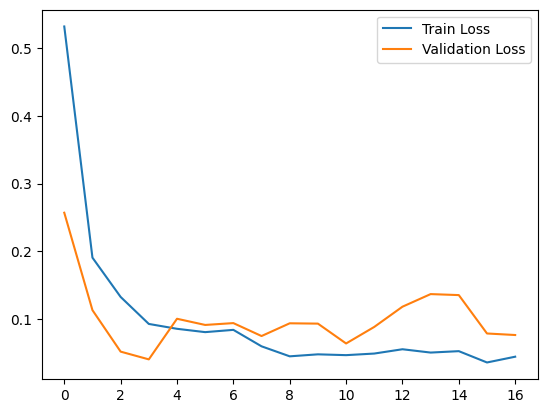

In [17]:
plt.plot(dense_hist.history['loss'], label='Train Loss')
plt.plot(dense_hist.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

Epoch 1/15
165/165 [==============================] - 73s 430ms/step - loss: 0.1834 - accuracy: 0.9324 - f1_score: 0.9366 - val_loss: 0.0762 - val_accuracy: 0.9758 - val_f1_score: 0.9587
Epoch 2/15
165/165 [==============================] - 99s 600ms/step - loss: 0.0656 - accuracy: 0.9793 - f1_score: 0.9796 - val_loss: 0.1127 - val_accuracy: 0.9710 - val_f1_score: 0.9500
Epoch 3/15
165/165 [==============================] - 76s 462ms/step - loss: 0.0405 - accuracy: 0.9896 - f1_score: 0.9896 - val_loss: 0.0699 - val_accuracy: 0.9758 - val_f1_score: 0.9580
Epoch 4/15
165/165 [==============================] - 70s 425ms/step - loss: 0.0273 - accuracy: 0.9920 - f1_score: 0.9921 - val_loss: 0.0363 - val_accuracy: 0.9831 - val_f1_score: 0.9702
Epoch 5/15
165/165 [==============================] - 69s 415ms/step - loss: 0.0219 - accuracy: 0.9939 - f1_score: 0.9940 - val_loss: 0.0624 - val_accuracy: 0.9831 - val_f1_score: 0.9705
Epoch 6/15
165/165 [==============================] - 74s 452ms/s

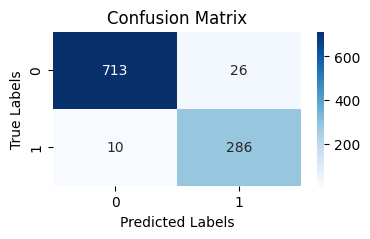

{'Accuracy (%)': '96.52',
 'Precision (%)': '91.67',
 'Recall (%)': '96.62',
 'F1-Score (%)': '94.08'}

In [18]:
# Reshape for CNN
X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val_cnn = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)

# Convolutional Neural Network (CNN)
model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1],1)),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),
        Flatten(),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_metric])

cnn_hist = model.fit(X_train_cnn, y_train, validation_data=(X_val_cnn, y_val), epochs=15, 
                 batch_size=32, verbose=1, class_weight = class_weight_dict)

# Evaluate the model
y_proba = model.predict(X_test)  # Predicted probabilities
y_pred = (y_proba > 0.5).astype(int) # final prediction 
y_true = np.array(y_test)    # true label

score(y_true, y_pred, y_proba)

In [19]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.96      0.98       739
           1       0.92      0.97      0.94       296

    accuracy                           0.97      1035
   macro avg       0.95      0.97      0.96      1035
weighted avg       0.97      0.97      0.97      1035



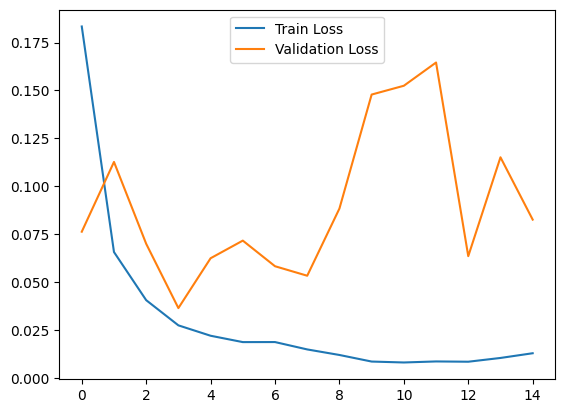

In [20]:
plt.plot(cnn_hist.history['loss'], label='Train Loss')
plt.plot(cnn_hist.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

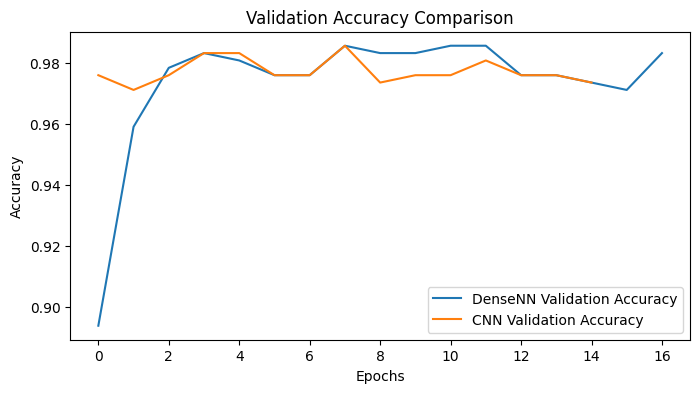

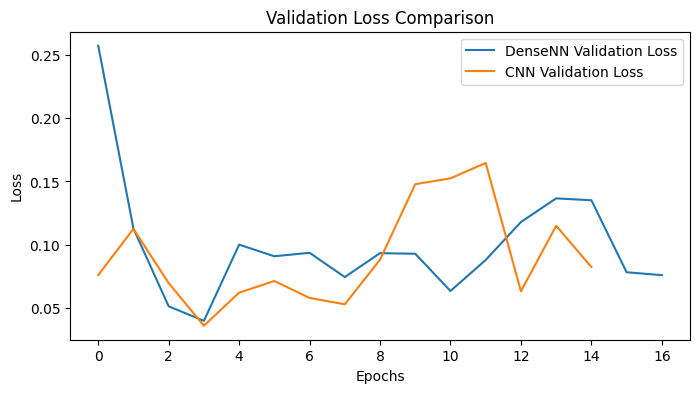

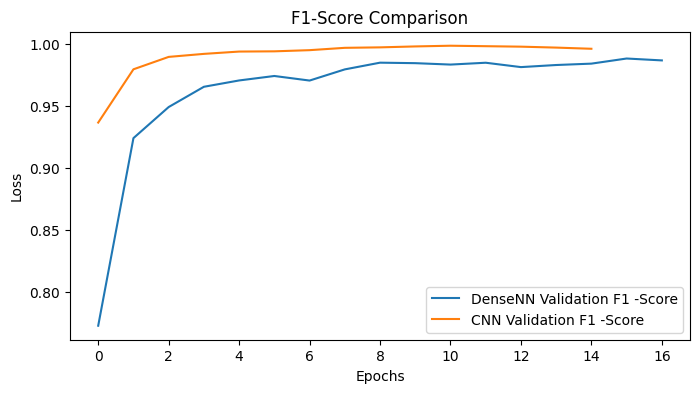

In [25]:
histories = {"DenseNN": dense_hist, "CNN": cnn_hist}

# Plot Accuracy and Loss Curves
plt.figure(figsize=(8, 4))
for model_name, history in histories.items():
    plt.plot(history.history['val_accuracy'], label=f'{model_name} Validation Accuracy')

plt.title("Validation Accuracy Comparison")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.figure(figsize=(8, 4))
for model_name, history in histories.items():
    plt.plot(history.history['val_loss'], label=f'{model_name} Validation Loss')

plt.title("Validation Loss Comparison")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8, 4))
for model_name, history in histories.items():
    plt.plot(history.history['f1_score'], label=f'{model_name} Validation F1 -Score')

plt.title("F1-Score Comparison")
plt.xlabel("Epochs")
plt.ylabel("F1-Score")
plt.legend()
plt.show()

Epoch 1/8
83/83 [==============================] - 881s 11s/step - loss: 0.7490 - accuracy: 0.4979 - f1_score: 0.6680 - val_loss: 0.9169 - val_accuracy: 0.2802 - val_f1_score: 0.4377
Epoch 2/8
83/83 [==============================] - 881s 11s/step - loss: 0.7312 - accuracy: 0.5000 - f1_score: 0.6667 - val_loss: 0.9839 - val_accuracy: 0.2802 - val_f1_score: 0.4377
Epoch 3/8
83/83 [==============================] - 871s 10s/step - loss: 0.7284 - accuracy: 0.5000 - f1_score: 0.6667 - val_loss: 0.9722 - val_accuracy: 0.2802 - val_f1_score: 0.4377
Epoch 4/8
83/83 [==============================] - 840s 10s/step - loss: 0.7260 - accuracy: 0.5011 - f1_score: 0.6672 - val_loss: 0.9529 - val_accuracy: 0.2802 - val_f1_score: 0.4377
Epoch 5/8
83/83 [==============================] - 864s 10s/step - loss: 0.7224 - accuracy: 0.5023 - f1_score: 0.6674 - val_loss: 0.9655 - val_accuracy: 0.2802 - val_f1_score: 0.4377
Epoch 6/8
83/83 [==============================] - 869s 10s/step - loss: 0.7192 - acc

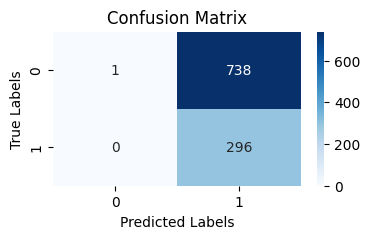

{'Accuracy (%)': '28.70',
 'Precision (%)': '28.63',
 'Recall (%)': '100.00',
 'F1-Score (%)': '44.51'}

In [77]:
# Reshape for LSTM (sequence length = feature count)
X_train_lstm = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val_lstm = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)

# Long Short-Term Memory (LSTM)
model = Sequential([
        LSTM(64, input_shape=( X_train.shape[1], 1), return_sequences=True),
        Dropout(0.3),
        LSTM(32),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_metric])

hist = model.fit(X_train_lstm, y_train, validation_data=(X_val_lstm, y_val), epochs=8,
                 batch_size=64, verbose=1, class_weight = class_weight_dict)

# Evaluate the model
y_proba = model.predict(X_test)  # Predicted probabilities
y_pred = (y_proba > 0.5).astype(int) # final prediction 
y_true = np.array(y_test)    # true label

score(y_true, y_pred, y_proba)

In [78]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.00      0.00       739
           1       0.29      1.00      0.45       296

    accuracy                           0.29      1035
   macro avg       0.64      0.50      0.22      1035
weighted avg       0.80      0.29      0.13      1035



In [26]:
results = {
    "Model": ["DenseNN", "CNN", "LSTM"],
    "Train Accuracy": [0.99, 1, 0.5],
    "Validation Accuracy": [0.98, 0.97, 0.28],
    "Test Accuracy": [0.96, 0.97, 0.29],
    "Precision": [0.90, 0.92, 0.28],
    "Recall": [0.97, 0.97, 1],
    "F1-Score": [0.93, 0.94, 0.44]
}

df = pd.DataFrame(results)
df

,Model,Train Accuracy,Validation Accuracy,Test Accuracy,Precision,Recall,F1-Score
0,DenseNN,0.99,0.98,0.96,0.90,0.97,0.93
1,CNN,1.00,0.97,0.97,0.92,0.97,0.94
2,LSTM,0.50,0.28,0.29,0.28,1.00,0.44


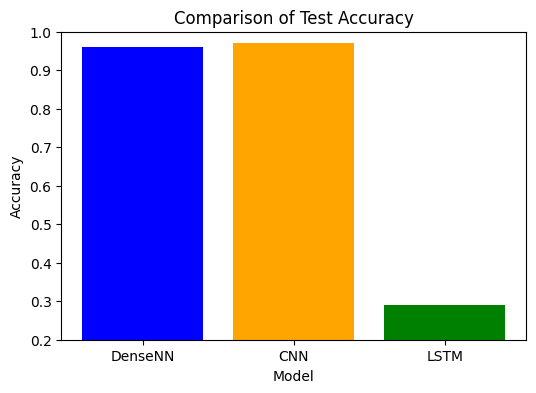

In [28]:
# Bar Plot for Test Accuracy
plt.figure(figsize=(6, 4))
plt.bar(df["Model"], df["Test Accuracy"], color=['blue', 'orange', 'green'])
plt.title("Comparison of Test Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Model")
plt.ylim(0.2, 1.0)  
plt.show()


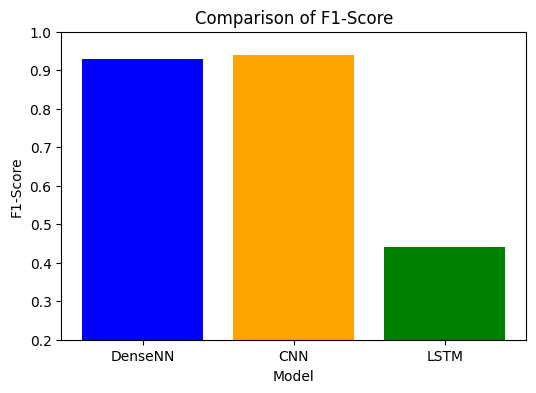

In [29]:
# Bar Plot for F1-Score
plt.figure(figsize=(6, 4))
plt.bar(df["Model"], df["F1-Score"], color=['blue', 'orange', 'green'])
plt.title("Comparison of F1-Score")
plt.ylabel("F1-Score")
plt.xlabel("Model")
plt.ylim(0.2, 1.0)  
plt.show()

Undersampling for Data Balancing.

Undersampling is a technique used to address class imbalance in a dataset by reducing the number of samples in the majority class so that it is balanced with the minority class.  Cluster Centroids replace the majority class with centroids of clusters formed within the majority class.

In [ ]:
X = dt.iloc[:, 1:-1].values  # Exclude 'Email No.' and 'Prediction'
y = dt['Prediction'].values

cc = ClusterCentroids(random_state=42)
X_res, y_res = cc.fit_resample(X, y)

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state = 50)

# Further split of the training set (90% train, 10% validation from training data)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.10, random_state=42
)

# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

# Compute Class Weights
class_weights1 = compute_class_weight('balanced', classes=[0, 1], y=y_train)
class_weight_dict1 = dict(enumerate(class_weights1))

In [21]:
# Check class distribution
print("Train class value count:")
print(pd.Series(y_train).value_counts())

print("Validation class value count:")
print(pd.Series(y_val).value_counts())

print("Test class value count:")
print(pd.Series(y_test).value_counts())

Train class value count:
1    1087
0    1073
Name: count, dtype: int64
Validation class value count:
0    122
1    118
Name: count, dtype: int64
Test class value count:
0    305
1    295
Name: count, dtype: int64


Epoch 1/15
68/68 [==============================] - 31s 425ms/step - loss: 0.2377 - accuracy: 0.9051 - f1_score: 0.9141 - val_loss: 0.1639 - val_accuracy: 0.9458 - val_f1_score: 0.9478
Epoch 2/15
68/68 [==============================] - 31s 453ms/step - loss: 0.0797 - accuracy: 0.9810 - f1_score: 0.9812 - val_loss: 0.1189 - val_accuracy: 0.9625 - val_f1_score: 0.9623
Epoch 3/15
68/68 [==============================] - 48s 711ms/step - loss: 0.0469 - accuracy: 0.9912 - f1_score: 0.9913 - val_loss: 0.1009 - val_accuracy: 0.9500 - val_f1_score: 0.9487
Epoch 4/15
68/68 [==============================] - 36s 528ms/step - loss: 0.0329 - accuracy: 0.9926 - f1_score: 0.9927 - val_loss: 0.1184 - val_accuracy: 0.9542 - val_f1_score: 0.9524
Epoch 5/15
68/68 [==============================] - 32s 467ms/step - loss: 0.0167 - accuracy: 0.9977 - f1_score: 0.9977 - val_loss: 0.1124 - val_accuracy: 0.9750 - val_f1_score: 0.9746
Epoch 6/15
68/68 [==============================] - 31s 460ms/step - loss: 

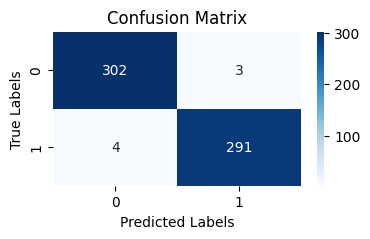

{'Accuracy (%)': '98.83',
 'Precision (%)': '98.98',
 'Recall (%)': '98.64',
 'F1-Score (%)': '98.81'}

In [47]:
# Reshape for CNN
X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val_cnn = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)

# Convolutional Neural Network (CNN)
model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1],1)),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),
        Flatten(),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_metric])

cnn_hist = model.fit(X_train_cnn, y_train, validation_data=(X_val_cnn, y_val), epochs=15, 
                 batch_size=32, verbose=1, class_weight = class_weight_dict1)

# Evaluate the model
y_proba = model.predict(X_test)  # Predicted probabilities
y_pred = (y_proba > 0.5).astype(int) # final prediction 
y_true = np.array(y_test)    # true label

score(y_true, y_pred, y_proba)

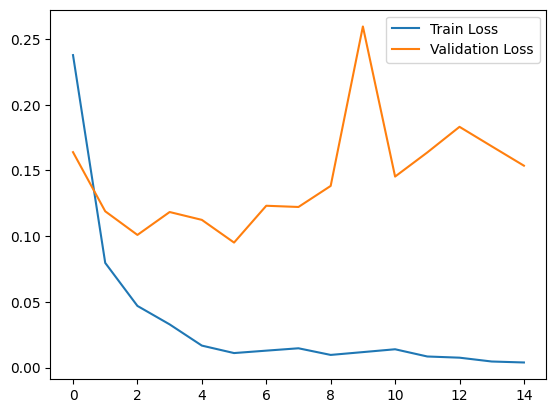

In [48]:
plt.plot(hist.history['loss'], label='Train Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

Epoch 1/10
68/68 - 4s - loss: 0.4325 - accuracy: 0.7940 - f1_score: 0.8187 - val_loss: 0.1198 - val_accuracy: 0.9500 - val_f1_score: 0.9504 - 4s/epoch - 58ms/step
Epoch 2/10
68/68 - 0s - loss: 0.0779 - accuracy: 0.9764 - f1_score: 0.9766 - val_loss: 0.1163 - val_accuracy: 0.9750 - val_f1_score: 0.9752 - 472ms/epoch - 7ms/step
Epoch 3/10
68/68 - 0s - loss: 0.0310 - accuracy: 0.9894 - f1_score: 0.9895 - val_loss: 0.1019 - val_accuracy: 0.9875 - val_f1_score: 0.9874 - 478ms/epoch - 7ms/step
Epoch 4/10
68/68 - 0s - loss: 0.0155 - accuracy: 0.9963 - f1_score: 0.9963 - val_loss: 0.2082 - val_accuracy: 0.9667 - val_f1_score: 0.9672 - 468ms/epoch - 7ms/step
Epoch 5/10
68/68 - 1s - loss: 0.0141 - accuracy: 0.9958 - f1_score: 0.9959 - val_loss: 0.2009 - val_accuracy: 0.9833 - val_f1_score: 0.9833 - 505ms/epoch - 7ms/step
Epoch 6/10
68/68 - 1s - loss: 0.0434 - accuracy: 0.9931 - f1_score: 0.9931 - val_loss: 0.2042 - val_accuracy: 0.9792 - val_f1_score: 0.9793 - 582ms/epoch - 9ms/step
Epoch 7/10
6

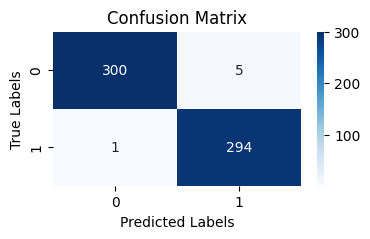

{'Accuracy (%)': '99.00',
 'Precision (%)': '98.33',
 'Recall (%)': '99.66',
 'F1-Score (%)': '98.99'}

In [39]:
# Dense Neural Network
model = Sequential([
        Dense(32, activation='relu', input_dim=X_train.shape[1]),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_metric])


# Fit the model
dense_hist=model.fit(X_train,
               y_train,
               epochs=10,
               batch_size=32,
               validation_data=(X_val,y_val),
               verbose=2, class_weight = class_weight_dict1)

# Evaluate the model
threshold = 0.5
y_proba = model.predict(X_test)  # Predicted probabilities
y_pred = (y_proba > threshold).astype(int)
y_true = np.array(y_test)    # true label

score(y_true, y_pred,y_proba)

In [40]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       305
           1       0.98      1.00      0.99       295

    accuracy                           0.99       600
   macro avg       0.99      0.99      0.99       600
weighted avg       0.99      0.99      0.99       600



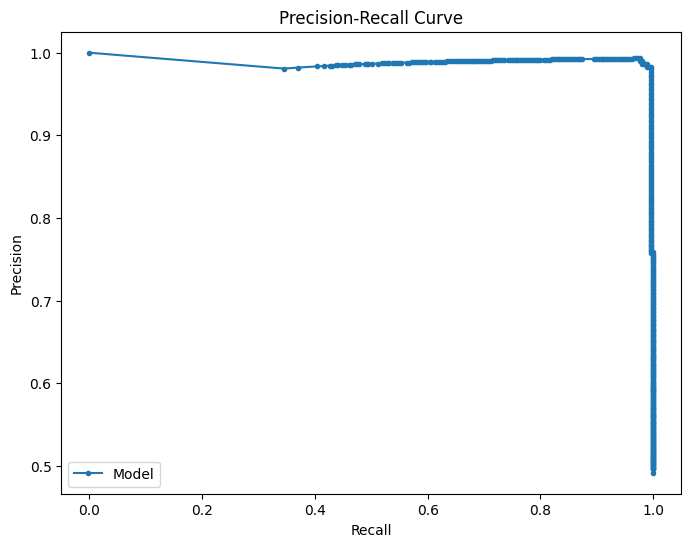

In [41]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label="Model")
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()

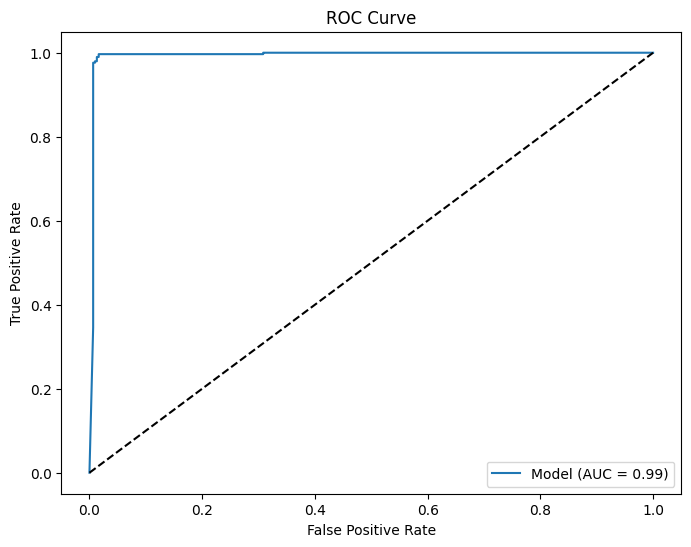

In [42]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Model (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

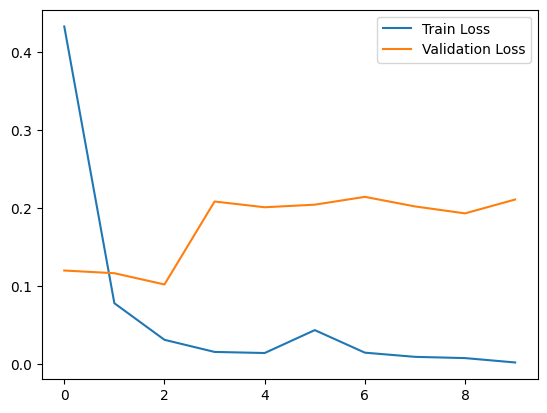

In [43]:
plt.plot(hist.history['loss'], label='Train Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [44]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_35 (Dense)            (None, 32)                96032     
                                                                 
 dropout_28 (Dropout)        (None, 32)                0         
                                                                 
 dense_36 (Dense)            (None, 64)                2112      
                                                                 
 dropout_29 (Dropout)        (None, 64)                0         
                                                                 
 dense_37 (Dense)            (None, 128)               8320      
                                                                 
 dropout_30 (Dropout)        (None, 128)               0         
                                                                 
 dense_38 (Dense)            (None, 32)               

In [8]:
results1 = {
    "Model": ["DenseNN", "CNN"],
    "Train Accuracy": [1, 1],
    "Validation Accuracy": [0.98, 0.97],
    "Test Accuracy": [0.99, 0.99],
    "Precision": [0.98, 0.99],
    "Recall": [1, 0.99],
    "F1-Score": [0.9899, 0.9881]
}

df1 = pd.DataFrame(results1)
df1

,Model,Train Accuracy,Validation Accuracy,Test Accuracy,Precision,Recall,F1-Score
0,DenseNN,1,0.98,0.99,0.98,1.00,0.9899
1,CNN,1,0.97,0.99,0.99,0.99,0.9881


In [45]:
# Save the model
model.save('final_model')

INFO:tensorflow:Assets written to: final_model\assets


INFO:tensorflow:Assets written to: final_model\assets


19/19 [==============================] - 0s 5ms/step


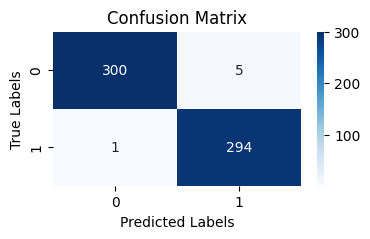

{'Accuracy (%)': '99.00',
 'Precision (%)': '98.33',
 'Recall (%)': '99.66',
 'F1-Score (%)': '98.99'}

In [46]:
# Reload the model
from tensorflow.keras.models import load_model
model = load_model('final_model')

dt = pd.read_csv('emails.csv')

X = dt.iloc[:, 1:-1].values  # Exclude 'Email No.' and 'Prediction'
y = dt['Prediction'].values

cc = ClusterCentroids(random_state=42)
X_res, y_res = cc.fit_resample(X, y)

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state = 50)

# Normalize the data
scaler = StandardScaler()
X_test = scaler.transform(X_test)

# Evaluate the model
y_proba = model.predict(X_test)  # Predicted probabilities
y_pred = (y_proba > 0.5).astype(int)
y_true = np.array(y_test)    # true label

score(y_true, y_pred,y_proba)